We have a few figures in the paper specific to SFRs from Harris+2016.  To include the LOFAR objects, let's make those figures separately in this notebook...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
%matplotlib inline
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [3]:
vla = pd.read_csv("../SpringFinalFigs_moreParams.csv")
S3 = vla[["int_flux"]].values.flatten()
z_vla = vla[["redshift_1"]].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
det_vla = (vla[["detection"]].values.flatten()==1)
ew_vla = vla[["ICA_CIV_EQW"]].values.flatten() / (1+z_vla)
Mi_vla = vla[["MI_Z2"]].values.flatten()
SFRavg_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.
vla.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,col1,name,follow_up,RMS,peak_flux,PFerr,...,Separation,ICA_CIV_BLUESHIFT,ICA_CIV_EQW,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721
0,0,0,0,0,233,SDSSJ001342.45-002412.6,0,9.8,163.0,17.0,...,0.000422,1488.886594,101.160257,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.486282
1,1,1,1,1,293,SDSSJ014023.83+141151.7,0,25.0,516.0,27.0,...,0.002490,172.315874,95.079534,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.589717
2,2,2,2,2,1270,SDSSJ014658.21-091505.2,0,10.0,30.0,NaN,...,0.003016,406.588017,97.289514,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.704345
3,3,3,3,3,1281,SDSSJ015720.27-093809.1,0,14.3,42.9,NaN,...,0.003151,557.606423,122.740901,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.635554
4,4,4,4,4,7944,SDSSJ081656.84+492438.1,1,8.7,26.1,NaN,...,0.010092,1250.742184,102.881571,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.289712


In [4]:
lofar = pd.read_csv("LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("col1", inplace=True)
lofar_det = pd.read_csv("LOFAR_from8403colorselected_detections123_1arcsec.csv")
lofar_det.sort_values("col1", inplace=True)
lofar_det.head()

,col1,name,RA_1,Dec_1,Source_Name,RA_2,E_RA,E_RA_tot,DEC_2,E_DEC,...,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id,Separation
0,1596,150855.76+543551.1,227.232351,54.597534,ILTJ150855.75+543551.0,227.232303,0.513256,0.545390,54.597517,0.429279,...,0.801843,123.827401,27.231359,123.827401,27.231359,0.115406,S,P227+53,2666,0.117538
1,1597,150458.47+541945.0,226.243631,54.329169,ILTJ150458.36+541944.9,226.243165,0.585375,0.599968,54.329150,0.303656,...,0.562968,111.743927,17.220519,0.000000,17.220519,0.092353,S,P223+55,129,0.980656
2,1598,150636.17+542354.4,226.650744,54.398453,ILTJ150636.20+542354.5,226.650828,0.488406,0.522071,54.398488,0.418312,...,0.978034,99.999269,73.754655,99.999269,73.754655,0.164218,S,P227+53,3362,0.216721
3,1830,110039.04+510902.3,165.162686,51.150642,ILTJ110039.05+510902.2,165.162688,0.136256,0.156984,51.150616,0.144476,...,0.317960,20.380242,55.903120,20.380242,55.903120,0.067429,S,P4Hetdex16,2296,0.093947
4,1832,110853.98+522337.9,167.224924,52.393875,ILTJ110853.96+522337.6,167.224854,0.486835,0.516670,52.393796,0.299093,...,0.700402,84.536970,24.364421,0.000000,24.364421,0.075898,S,P8Hetdex,4605,0.324757


In [9]:
c1 = lofar[["name"]].values.flatten() #can use this to pick out detections from Amy's file
c1_det = lofar_det[["name"]].values.flatten()
D_lofar = np.array([])
for i in range(len(c1)):
    if (c1[i]==c1_det).any():
        D_lofar = np.append(D_lofar, True)
    else:
        D_lofar = np.append(D_lofar, False)

det_lofar = (D_lofar==1.)
det_lofar.sum()

123

In [27]:
S144 = 210.*np.ones(len(lofar)) #initialize all objects to non-detections (70µJy*3)
S144[det_lofar] = lofar_det[["Total_flux"]].values.flatten()*1.e3
z_lofar = lofar[["z_paul"]].values.flatten()
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar[["CIV_EW"]].values.flatten()
voff_lofar = lofar[["CIV_blue"]].values.flatten()
Mi_lofar = lofar[["MI_Z2"]].values.flatten()

In [28]:
#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw_vla = 1.7e21*SFR_eqw(ew_vla)
L14_Mi_vla = 1.7e21*SFR_Mi(Mi_vla)
L14_vla = 10.**radluminosity(1.4, 3., S3, -0.7, z_vla)
bins_vla = np.logspace(np.log10(min(min(L14_eqw_vla[L14_eqw_vla>0.]), min(L14_Mi_vla[L14_Mi_vla>0.]))), np.log10(max(L14_vla)), 35)

L14_eqw_lof = 1.7e21*SFR_eqw(ew_lofar)
L14_Mi_lof = 1.7e21*SFR_Mi(Mi_lofar)
L14_lof = 10.**radluminosity(1.4, .144, S144, -0.7, z_lofar)
bins_lof = np.logspace(np.log10(min(min(L14_eqw_lof[L14_eqw_lof>0.]), min(L14_Mi_lof[L14_Mi_lof>0.]))), np.log10(max(L14_lof)), 35)

----

## VLA-only

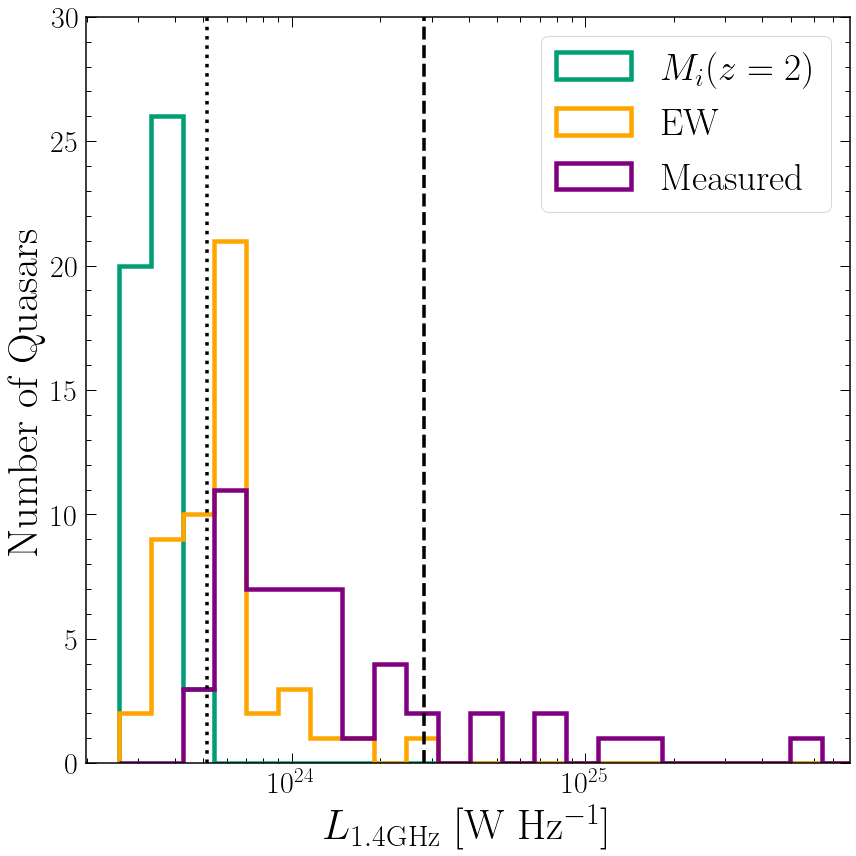

In [29]:
#Plot the inset on its own
fig = plt.figure(figsize=(12,12))

plt.hist([L14_vla, L14_eqw_vla, L14_Mi_vla], histtype="step", bins=bins_vla, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

plt.plot([10**24.45,10**24.45],[0,38],"--k",linewidth=3.5) #label="AGN dominate"
plt.plot([10**23.71,10**23.71],[0,38],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
plt.ylim([0,30])
plt.xlim([10.**23.3,10.**25.9])
plt.xscale("log")
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("Number of Quasars",fontsize=42.5)
plt.legend(loc="upper right", frameon=True, prop={"size":37.5})
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_SFRhisto_inset.pdf")

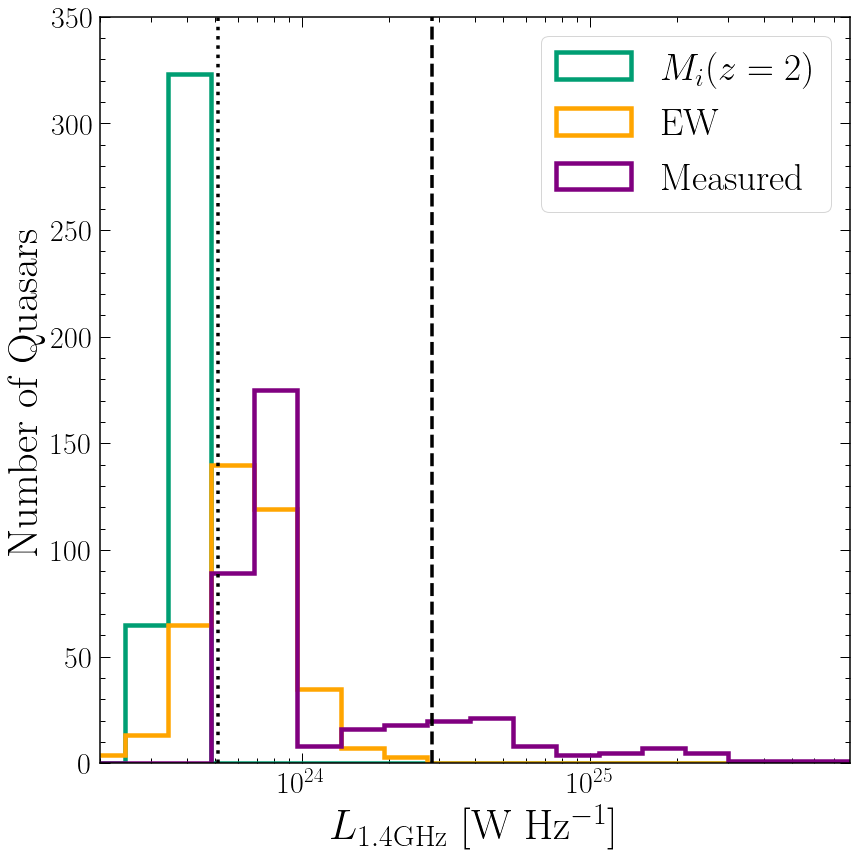

In [32]:
#Plot the inset on its own
fig = plt.figure(figsize=(12,12))

plt.hist([L14_lof, L14_eqw_lof, L14_Mi_lof], histtype="step", bins=bins_lof, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

plt.plot([10**24.45,10**24.45],[0,380],"--k",linewidth=3.5) #label="AGN dominate"
plt.plot([10**23.71,10**23.71],[0,380],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
plt.ylim([0,350])
plt.xlim([10.**23.3,10.**25.9])
plt.xscale("log")
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("Number of Quasars",fontsize=42.5)
plt.legend(loc="upper right", frameon=True, prop={"size":37.5})
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_SFRhisto_inset.pdf")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


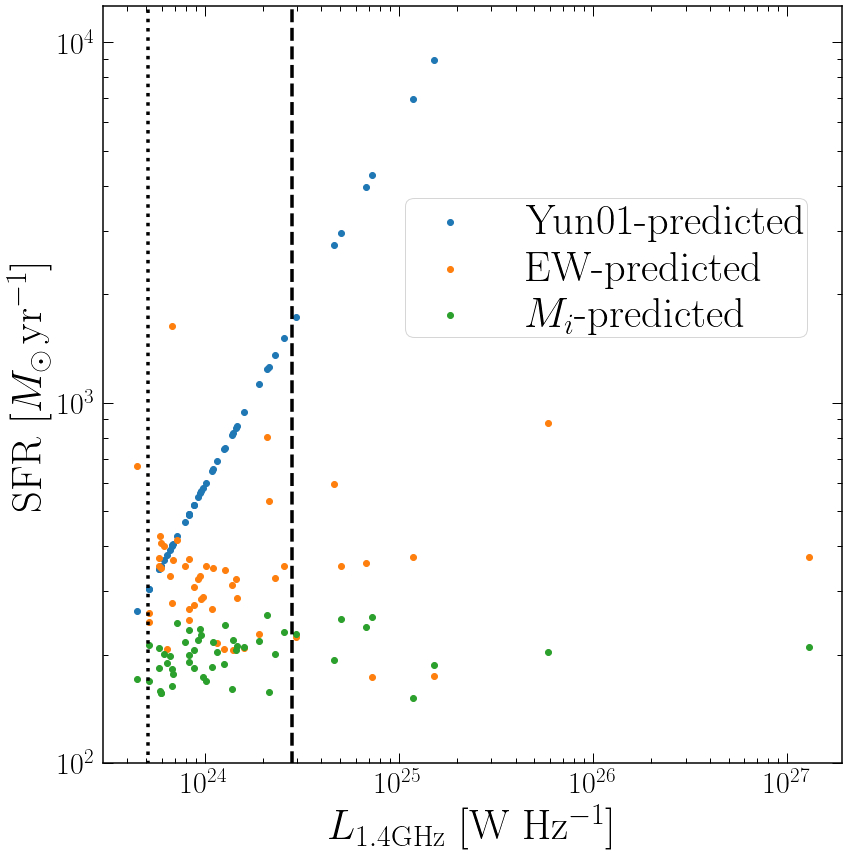

In [33]:
fig = plt.figure(figsize=(12,12))
plt.scatter(L14_vla, SFR_L14(radluminosity(1.4, 3., S3, -0.7, z_vla)), label="Yun01-predicted")
plt.scatter(L14_vla, SFR_eqw(ew_vla), label="EW-predicted")
plt.scatter(L14_vla, SFR_Mi(Mi_vla), label="$M_{i}$-predicted")
plt.plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
plt.plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#,label="Intended Flux Den. Limit")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100, 10**4.1)
#plt.xlim(10**23.55, 10**27.55)
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=42.5)
plt.legend(bbox_to_anchor=(0.38,0.775), prop={"size":42.5}, borderpad=0.05, labelspacing=0.11)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_SFRwlinesInset.pdf")

## LOFAR-only

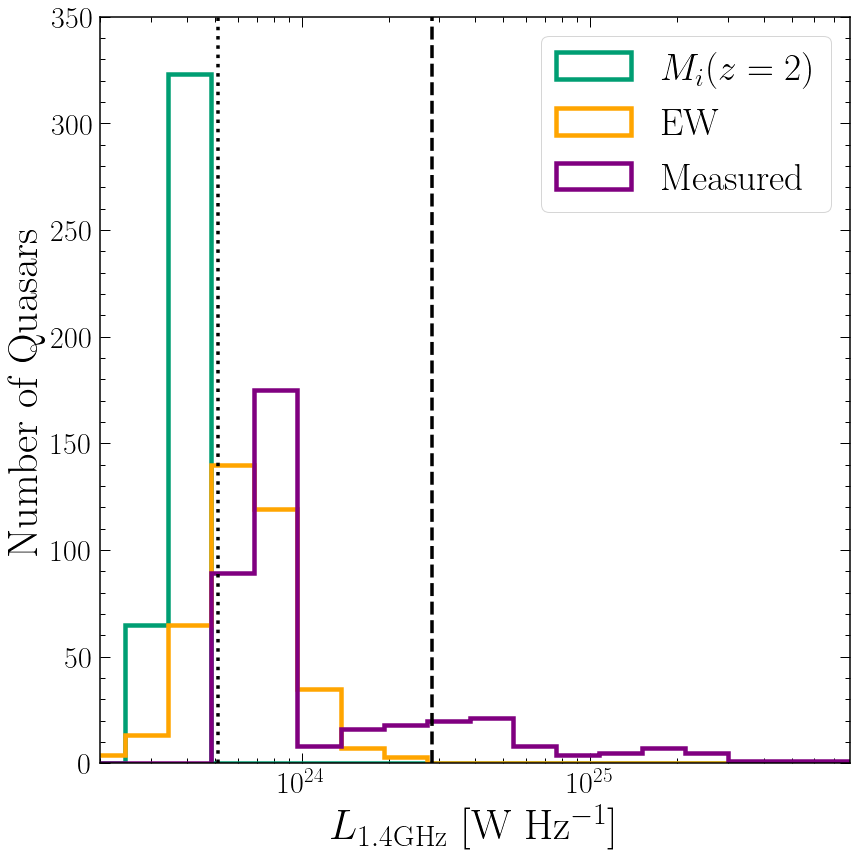

In [38]:
#Plot the inset on its own
fig = plt.figure(figsize=(12,12))

plt.hist([L14_lof, L14_eqw_lof, L14_Mi_lof], histtype="step", bins=bins_lof, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

plt.plot([10**24.45,10**24.45],[0,380],"--k",linewidth=3.5) #label="AGN dominate"
plt.plot([10**23.71,10**23.71],[0,380],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
plt.ylim([0,350])
plt.xlim([10.**23.3,10.**25.9])
plt.xscale("log")
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("Number of Quasars",fontsize=42.5)
plt.legend(loc="upper right", frameon=True, prop={"size":37.5})
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_SFRhisto_inset.pdf")

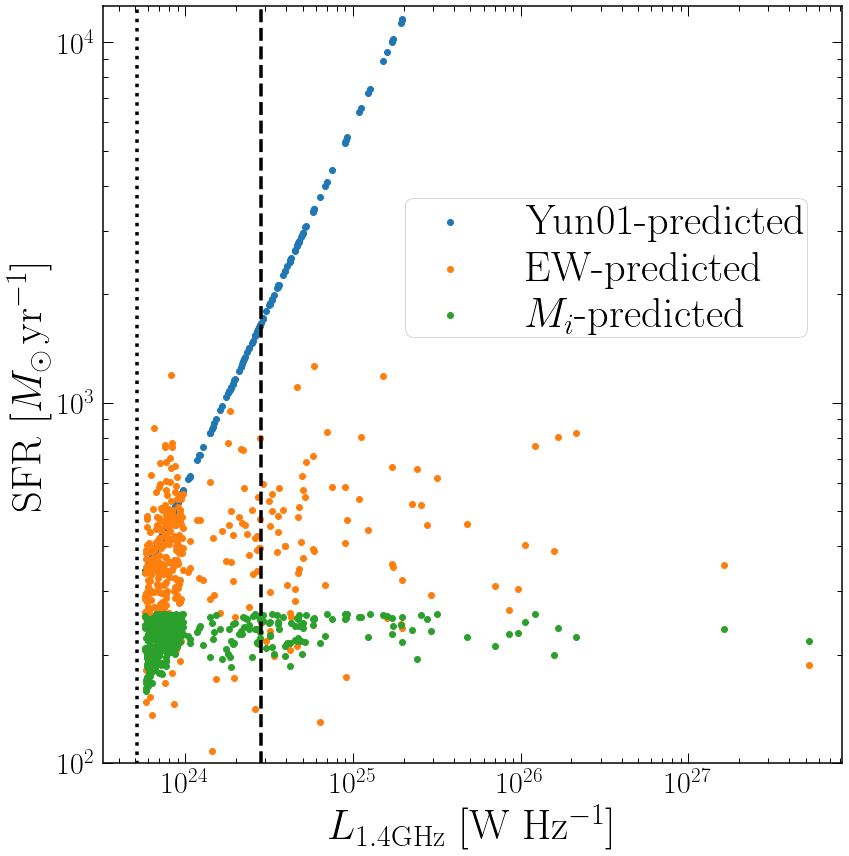

In [37]:
fig = plt.figure(figsize=(12,12))
plt.scatter(L14_lof, SFR_L14(radluminosity(1.4, .144, S144, -0.7, z_lofar)), label="Yun01-predicted")
plt.scatter(L14_lof, SFR_eqw(ew_lofar), label="EW-predicted")
plt.scatter(L14_lof, SFR_Mi(Mi_lofar), label="$M_{i}$-predicted")
plt.plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
plt.plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#,label="Intended Flux Den. Limit")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100, 10**4.1)
#plt.xlim(10**23.55, 10**27.55)
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=42.5)
plt.legend(bbox_to_anchor=(0.38,0.775), prop={"size":42.5}, borderpad=0.05, labelspacing=0.11)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_SFRwlinesInset.pdf")

---

Let's look at them both on top of each other

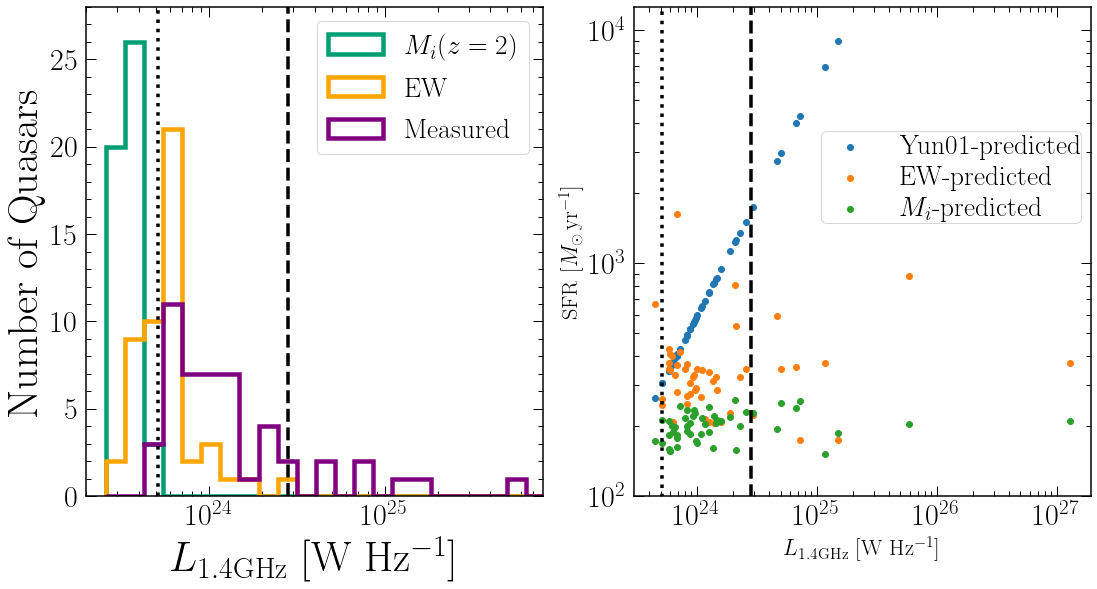

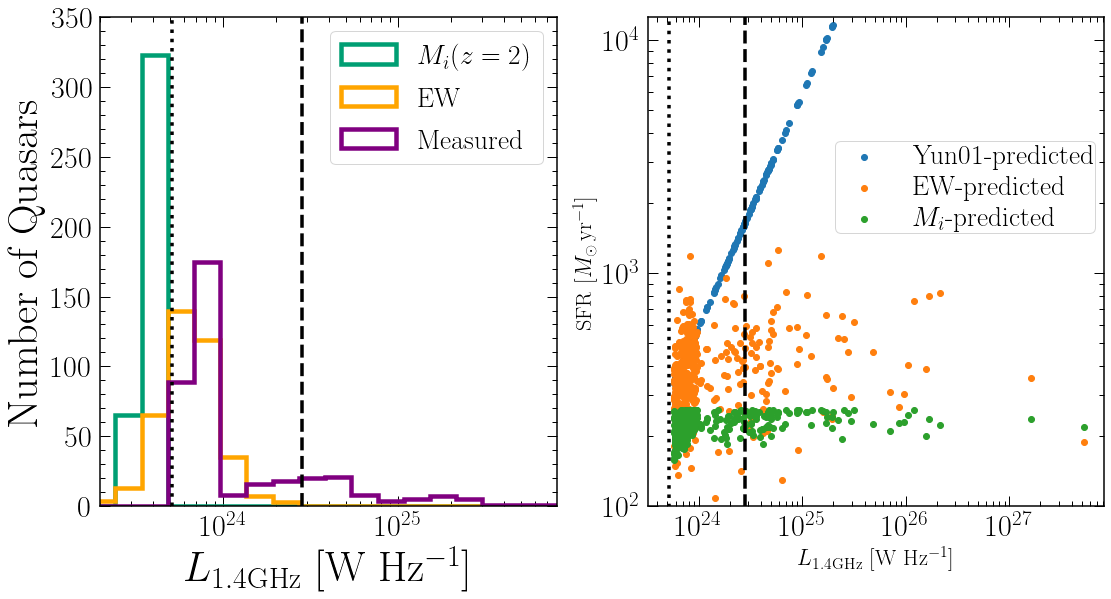

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(18,9))

ax[0].hist([L14_vla, L14_eqw_vla, L14_Mi_vla], histtype="step", bins=bins_vla, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

ax[0].plot([10**24.45,10**24.45],[0,380],"--k",linewidth=3.5) #label="AGN dominate"
ax[0].plot([10**23.71,10**23.71],[0,380],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
ax[0].set_ylim([0,28])
ax[0].set_xlim([10.**23.3,10.**25.9])
ax[0].set_xscale("log")
ax[0].set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
ax[0].set_ylabel("Number of Quasars",fontsize=42.5)
ax[0].legend(loc="upper right", frameon=True, prop={"size":27.5})
ax[0].tick_params(axis='both', which='major', labelsize=30)

ax[1].scatter(L14_vla, SFR_L14(radluminosity(1.4, 3., S3, -0.7, z_vla)), label="Yun01-predicted")
ax[1].scatter(L14_vla, SFR_eqw(ew_vla), label="EW-predicted")
ax[1].scatter(L14_vla, SFR_Mi(Mi_vla), label="$M_{i}$-predicted")
ax[1].plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
ax[1].plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#,label="Intended Flux Den. Limit")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim(100, 10**4.1)
#ax[1].set_xlim(10**23.55, 10**27.55)
ax[1].set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=22.5)
ax[1].set_ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=22.5)
ax[1].legend(bbox_to_anchor=(0.38,0.775), prop={"size":27.5}, borderpad=0.05, labelspacing=0.11)
ax[1].tick_params(axis='both', which='major', labelsize=30)

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18,9))

axs[0].hist([L14_lof, L14_eqw_lof, L14_Mi_lof], histtype="step", bins=bins_lof, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

axs[0].plot([10**24.45,10**24.45],[0,380],"--k",linewidth=3.5) #label="AGN dominate"
axs[0].plot([10**23.71,10**23.71],[0,380],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
axs[0].set_ylim([0,350])
axs[0].set_xlim([10.**23.3,10.**25.9])
axs[0].set_xscale("log")
axs[0].set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
axs[0].set_ylabel("Number of Quasars",fontsize=42.5)
axs[0].legend(loc="upper right", frameon=True, prop={"size":27.5})
axs[0].tick_params(axis='both', which='major', labelsize=30)

axs[1].scatter(L14_lof, SFR_L14(radluminosity(1.4, .144, S144, -0.7, z_lofar)), label="Yun01-predicted")
axs[1].scatter(L14_lof, SFR_eqw(ew_lofar), label="EW-predicted")
axs[1].scatter(L14_lof, SFR_Mi(Mi_lofar), label="$M_{i}$-predicted")
axs[1].plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
axs[1].plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#,label="Intended Flux Den. Limit")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(100, 10**4.1)
#axs[1].set_xlim(10**23.55, 10**27.55)
axs[1].set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=22.5)
axs[1].set_ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=22.5)
axs[1].legend(bbox_to_anchor=(0.38,0.775), prop={"size":27.5}, borderpad=0.05, labelspacing=0.11)
axs[1].tick_params(axis='both', which='major', labelsize=30)

Note that the y-axes are cut off in both of the right-hand panels - that linear Yun01 trend will extend out to the rightmost point along the x-axis